Total frames: 37782, sequences: 179
Train frames before aug: 30508
Train frames after  aug: 122032
Windowed data — train: (116312, 451), test: (6914, 451)

⏳ Running GridSearchCV over 1 configs × 5-fold CV

Fitting 5 folds for each of 1 candidates, totalling 5 fits

🏆 Best hyper-parameters:
   • batch_size          : 128
   • epochs              : 50
   • model__n_layers     : 12
   • model__units        : 128
   • optimizer__learning_rate: 0.0001
Best CV F1-score : 0.9625215146343393

Windowed-test → loss 0.3438  acc 0.9229  precision 0.9497  recall 0.9405  F1 0.9451

───────── Per-video boundary error ─────────
A10_kinect.csv:  GT [  42,  202]  |  Pred [  36,  205]  →  Δstart   -6  Δend   +3
A115_kinect.csv:  GT [  65,  168]  |  Pred [  57,  148]  →  Δstart   -8  Δend  -20
A116_kinect.csv:  GT [   0,  213]  |  Pred [   5,  161]  →  Δstart   +5  Δend  -52
A118_kinect.csv:  GT [   0,  129]  |  Pred [   5,  134]  →  Δstart   +5  Δend   +5
A119_kinect.csv:  GT [   0,  166]  |  Pred [   5

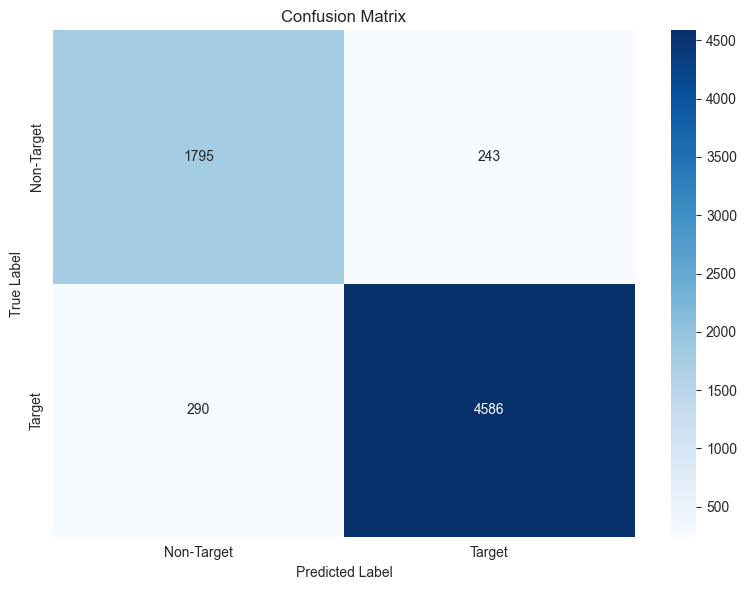


───────── Confusion Matrix Metrics ─────────
Accuracy:  0.9229
Precision: 0.9497
Recall:    0.9405
F1 Score:  0.9451

───────── Aggregate boundary error ─────────
Δstart  mean  +3.00 ± 17.51   median |Δ| 4.0 frames
Δend    mean  -1.61 ± 14.26   median |Δ| 4.0 frames

💾  Model saved to kinect_cutting_model_with_distances.keras


In [6]:
import re
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import make_scorer, f1_score
import tensorflow as tf
from keras import layers, models, callbacks
from scikeras.wrappers import KerasClassifier
from joblib import dump
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ======================================================================
# 1.  LOAD & SPLIT
# ======================================================================
def load_squat_binary_matched(uncut_dir, cut_dir):
    uncut = {f for f in os.listdir(uncut_dir) if f.endswith("_kinect.csv")}
    cut = {f for f in os.listdir(cut_dir) if f.endswith("_kinect.csv")}
    matched = sorted(uncut & cut, key=lambda f: re.match(r'^([A-Z])(\d+)', f).groups())

    X_parts, y_parts, groups = [], [], []
    for fn in matched:
        df_full = pd.read_csv(os.path.join(uncut_dir, fn))
        df_cut = pd.read_csv(os.path.join(cut_dir, fn))
        cut_set = set(df_cut["FrameNo"])
        X_parts.append(df_full.drop(columns=["FrameNo"]))
        y_parts.append(df_full["FrameNo"].isin(cut_set).astype(int))
        groups.extend([fn] * len(df_full))

    X = pd.concat(X_parts, ignore_index=True)
    y = pd.concat(y_parts, ignore_index=True)
    return X, y, np.array(groups)

UNCUT = "data/kinect_good"
CUT = "data/kinect_good_preprocessed"

X, y, groups = load_squat_binary_matched(UNCUT, CUT)
print(f"Total frames: {len(y)}, sequences: {len(np.unique(groups))}")

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train = X.loc[train_idx].copy()  # Explicitly create a copy
X_test = X.loc[test_idx].copy()    # Explicitly create a copy
y_train, groups_train = y[train_idx], groups[train_idx]
y_test, groups_test = y[test_idx], groups[test_idx]

# strip accidental whitespace in column names
X_train.columns = X_train.columns.str.strip()
X_test.columns = X_test.columns.str.strip()

# ======================================================================
# 2.  FEATURE ENGINEERING (Distance Calculation)
# ======================================================================

def calculate_distance(df, joint1_base, joint2_base):
    """
    Calculates the Euclidean distance between two joints.

    Args:
        df (pd.DataFrame): DataFrame containing joint coordinates.
        joint1_base (str): Base name of the first joint (e.g., "left_shoulder").
        joint2_base (str): Base name of the second joint (e.g., "right_shoulder").

    Returns:
        pd.Series: Series containing the distance between the two joints.
    """

    x1 = df[f"{joint1_base}_x"].values
    y1 = df[f"{joint1_base}_y"].values
    z1 = df[f"{joint1_base}_z"].values if f"{joint1_base}_z" in df else np.zeros_like(x1)  # Handle 2D case
    x2 = df[f"{joint2_base}_x"].values
    y2 = df[f"{joint2_base}_y"].values
    z2 = df[f"{joint2_base}_z"].values if f"{joint2_base}_z" in df else np.zeros_like(x2)  # Handle 2D case

    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)

# Calculate distance between right_shoulder and right_knee
X_train['torso_left_knee_distance'] = calculate_distance(X_train, 'right_shoulder', 'left_knee') # Assuming 'right_shoulder' as a proxy for torso
X_test['torso_left_knee_distance'] = calculate_distance(X_test, 'right_shoulder', 'left_knee')

#Calculate distance between left_hip and right_knee
X_train['left_hip_right_knee_distance'] = calculate_distance(X_train, 'left_hip', 'right_knee')
X_test['left_hip_right_knee_distance'] = calculate_distance(X_test, 'left_hip', 'right_knee')


# ======================================================================
# 3.  DATA-AUGMENTATION (mirror + rotate)
# ======================================================================
JOINT_PAIRS = [
    ("left_shoulder", "right_shoulder"),
    ("left_elbow", "right_elbow"),
    ("left_hand", "right_hand"),
    ("left_hip", "right_hip"),
    ("left_knee", "right_knee"),
    ("left_foot", "right_foot"),
]

def mirror_df(df):
    m = df.copy()
    for c in m.columns:
        if c.endswith("_x"):
            m[c] = -m[c]
    for L, R in JOINT_PAIRS:
        for axis in ("x", "y", "z"):
            lcol, rcol = f"{L}_{axis}", f"{R}_{axis}"
            if lcol in m and rcol in m:
                m[lcol], m[rcol] = m[rcol].copy(), m[lcol].copy()


    return m

def rotate_df(df, angle):
    r = df.copy()
    c, s = np.cos(angle), np.sin(angle)
    for col in r.columns:
        if col.endswith("_x"):
            base = col[:-2]
            xcol, zcol = f"{base}_x", f"{base}_z"
            if zcol in r:
                x, z = df[xcol].values, df[zcol].values
                r[xcol] = c*x - s*z
                r[zcol] = s*x + c*z
    return r

aug_X = [X_train]
aug_y = [y_train]
aug_g = [groups_train]

aug_X.append(mirror_df(X_train));
aug_y.append(y_train.copy());
aug_g.append(groups_train.copy())
for ang in (np.deg2rad(15), np.deg2rad(-15)):
    aug_X.append(rotate_df(X_train, ang));
    aug_y.append(y_train.copy());
    aug_g.append(groups_train.copy())

X_train_aug = pd.concat(aug_X, ignore_index=True)
y_train_aug = pd.concat(aug_y, ignore_index=True)
groups_train_aug = np.concatenate(aug_g)

print("Train frames before aug:", len(X_train))
print("Train frames after  aug:", len(X_train_aug))

# ======================================================================
# 4.  SLIDING-WINDOWS
# ======================================================================
WINDOW = 11
HALF = WINDOW // 2

def build_windows(X_df, y_arr, g_arr):
    X_np = X_df.values
    X_win, y_win, centre_global_idx = [], [], []
    for i in range(HALF, len(X_np) - HALF):
        if np.all(g_arr[i - HALF: i + HALF + 1] == g_arr[i]):
            X_win.append(X_np[i - HALF: i + HALF + 1].ravel())
            y_win.append(y_arr[i])
            centre_global_idx.append(i)
    return np.stack(X_win), np.array(y_win), np.array(centre_global_idx)

X_win, y_win, centre_idx_train = build_windows(
    X_train_aug, y_train_aug.values, groups_train_aug
)
X_test_win, y_test_win, centre_idx_test = build_windows(
    X_test, y_test.values, groups_test
)

print(f"Windowed data — train: {X_win.shape}, test: {X_test_win.shape}")

# ======================================================================
# 5.  SCALING & CLASS-WEIGHTS
# ======================================================================
scaler = StandardScaler().fit(X_win)
X_tr = scaler.transform(X_win)
X_te = scaler.transform(X_test_win)

classes = np.unique(y_win)
cw = compute_class_weight(class_weight="balanced",
                            classes=classes,
                            y=y_win)
class_weight = dict(zip(classes, cw))

# ======================================================================
# 6.  MODEL FACTORY (parametrized for grid search)
# ======================================================================
def build_model(n_layers=2, units=64, learning_rate=0.001):
    m = models.Sequential()
    m.add(layers.Input(shape=(X_tr.shape[1],)))
    for _ in range(n_layers):
        m.add(layers.Dense(units, activation="relu"))
    m.add(layers.Dense(1, activation="sigmoid"))
    m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall")
        ]
    )
    return m

# ======================================================================
# 7.  GRID SEARCH CV
# ======================================================================
param_grid = {
    "model__n_layers": [12],  # medium vs. slightly deeper net
    "model__units": [128],  # moderate vs. higher capacity
    "optimizer__learning_rate": [1e-4],  # standard Adam LR vs. a smaller step
    "batch_size": [128],  # small vs. medium batches
    "epochs": [50],  # enough to converge vs. extra training
}

early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

reg = KerasClassifier(
    model=build_model,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=0
)

f1_scorer = make_scorer(f1_score)

grid = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=3
)

print(
    f"\n⏳ Running GridSearchCV over {np.prod([len(v) for v in param_grid.values()])} configs × {grid.cv}-fold CV\n")
grid_result = grid.fit(X_tr, y_win)

print("\n🏆 Best hyper-parameters:")
for k, v in grid_result.best_params_.items():
    print(f"   • {k:20s}: {v}")
print("Best CV F1-score :", grid_result.best_score_)

best_model = grid_result.best_estimator_.model_

# ======================================================================
# 8.  EVALUATION (use best_model)
# ======================================================================
loss, acc, prec, rec = best_model.evaluate(X_te, y_test_win, verbose=0)
f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
print(f"\nWindowed-test → loss {loss:.4f}  acc {acc:.4f}  precision {prec:.4f}  recall {rec:.4f}  F1 {f1:.4f}")

# ======================================================================
# 9.  BOUNDARY-ERROR EVALUATION WITH CONFUSION MATRIX
# ======================================================================
print("\n───────── Per-video boundary error ─────────")
delta_start_list, delta_end_list = [], []
per_video_results = {}

# For confusion matrix
all_true_labels = []
all_pred_labels = []

unique_test_vids = np.unique(groups_test)

for vid in unique_test_vids:
    frame_mask = (groups_test == vid)
    y_vid = y_test.values[frame_mask]
    X_vid_df = X_test.loc[frame_mask]
    n_frames = len(y_vid)
    if y_vid.sum() == 0 or n_frames < WINDOW:
        warnings.warn(f"{vid}: skipped (no positives or too short).")
        continue

    win_feats, centres = [], []
    for idx in range(HALF, n_frames - HALF):
        win_feats.append(X_vid_df.iloc[idx - HALF: idx + HALF + 1].values.ravel())
        centres.append(idx)

    X_vid_win = scaler.transform(np.stack(win_feats))
    pred_prob = best_model.predict(X_vid_win, verbose=0).ravel()
    pred_lbl = (pred_prob >= 0.5).astype(int)

    # Collect labels for confusion matrix
    all_true_labels.extend(y_test.values[frame_mask][HALF:n_frames-HALF])

    # Initialize predictions (only for frames within window range)
    frame_pred = np.zeros(n_frames, dtype=int)
    for c_idx, lbl in zip(centres, pred_lbl):
        frame_pred[c_idx] = lbl

    # Collect predictions for confusion matrix (only windowed frames)
    all_pred_labels.extend(frame_pred[HALF:n_frames-HALF])

    # Apply smoothing to remove isolated predictions
    for i in range(1, n_frames - 1):
        if frame_pred[i - 1] == frame_pred[i + 1] != frame_pred[i]:
            frame_pred[i] = frame_pred[i - 1]

    true_start = int(np.argmax(y_vid == 1))
    true_end = int(n_frames - 1 - np.argmax(y_vid[::-1] == 1))

    segments, in_seg = [], False
    for i, l in enumerate(frame_pred):
        if l == 1 and not in_seg:
            in_seg, seg_start = True, i
        if (l == 0 and in_seg) or (in_seg and i == n_frames - 1):
            seg_end = i - 1 if l == 0 else i
            segments.append((seg_start, seg_end))
            in_seg = False

    if not segments:
        print(f"{vid}: ❌  no segment predicted")
        continue

    seg_lens = [e - s + 1 for s, e in segments]
    idx_long = int(np.argmax(seg_lens))
    pred_start, pred_end = segments[idx_long]

    d_start = pred_start - true_start
    d_end = pred_end - true_end
    delta_start_list.append(d_start)
    delta_end_list.append(d_end)
    per_video_results[vid] = {
        "true": (true_start, true_end),
        "pred": (pred_start, pred_end),
        "delta": (d_start, d_end)
    }

    print(f"{vid}:  GT [{true_start:>4}, {true_end:>4}]  |  "
          f"Pred [{pred_start:>4}, {pred_end:>4}]  "
          f"→  Δstart {d_start:+4d}  Δend {d_end:+4d}")

# Generate and display confusion matrix
if all_true_labels:
    cm = confusion_matrix(all_true_labels, all_pred_labels)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Target', 'Target'],
                yticklabels=['Non-Target', 'Target'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_distances.png')
    plt.show()

    # Calculate metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print("\n───────── Confusion Matrix Metrics ─────────")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

if delta_start_list:
    ds = np.array(delta_start_list);
    de = np.array(delta_end_list)
    print("\n───────── Aggregate boundary error ─────────")
    print(f"Δstart  mean {ds.mean():+6.2f} ± {ds.std():.2f}   "
          f"median |Δ| {np.median(np.abs(ds)):.1f} frames")
    print(f"Δend    mean {de.mean():+6.2f} ± {de.std():.2f}   "
          f"median |Δ| {np.median(np.abs(de)):.1f} frames")
else:
    print("No boundary statistics (no positive predictions).")

# ======================================================================
# 10. SAVE ARTIFACTS
# ======================================================================
# Save the best model in Keras v3 format
best_model.save("kinect_cutting_model_with_distances.keras")

# Save the input scaler
dump(scaler, "kinect_cutting_scaler_with_distances.pkl")

print("\n💾  Model saved to kinect_cutting_model_with_distances.keras")

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

In [2]:
import sklearn
print(sklearn.__version__)

1.3.1


In [ ]:
def cut_sequence_with_distance_features(file_path, model_path="kinect_cutting_model_with_distances.keras",
                                        scaler_path="kinect_cutting_scaler_with_distances.pkl"):
    """Cut a sequence using the distance-feature enhanced model"""
    # Load the CSV file
    df = pd.read_csv(file_path)
    print(f"Loaded {file_path}: {len(df)} frames")

    # Calculate the distance feature
    df_features = df.drop(columns=["FrameNo"]).copy()
    df_features.columns = df_features.columns.str.strip()
    df_features['torso_left_knee_distance'] = calculate_distance(df_features, 'right_shoulder', 'left_knee')
    df_features['left_hip_right_knee_distance'] = calculate_distance(df_features, 'left_hip', 'right_knee')

    # Load model and scaler
    model = tf.keras.models.load_model(model_path)
    scaler = load(scaler_path)

    # Create windows
    n_frames = len(df_features)
    WINDOW = 11
    HALF = WINDOW // 2

    win_feats, centres = [], []
    for idx in range(HALF, n_frames - HALF):
        win_feats.append(df_features.iloc[idx-HALF : idx+HALF+1].values.ravel())
        centres.append(idx)

    if not win_feats:  # Sequence too short
        return df, 0, n_frames - 1

    # Preprocess and predict
    X_win = scaler.transform(np.stack(win_feats))
    pred_prob = model.predict(X_win, verbose=0).ravel()
    pred_lbl = (pred_prob >= 0.5).astype(int)

    # Initialize frame predictions
    frame_pred = np.zeros(n_frames, dtype=int)

    # Fill in predictions at window centers
    for c_idx, lbl in zip(centres, pred_lbl):
        frame_pred[c_idx] = lbl

    # Apply smoothing to remove isolated predictions
    for i in range(1, n_frames-1):
        if frame_pred[i-1] == frame_pred[i+1] != frame_pred[i]:
            frame_pred[i] = frame_pred[i-1]

    # Find segments
    segments, in_seg = [], False
    for i, l in enumerate(frame_pred):
        if l == 1 and not in_seg:
            in_seg, seg_start = True, i
        if (l == 0 and in_seg) or (in_seg and i == n_frames-1):
            seg_end = i-1 if l == 0 else i
            segments.append((seg_start, seg_end))
            in_seg = False

    # If no segments found, return original sequence
    if not segments:
        return df, 0, n_frames - 1

    # Select the longest segment
    seg_lens = [e - s + 1 for s, e in segments]
    idx_long = int(np.argmax(seg_lens))
    start_idx, end_idx = segments[idx_long]

    print(f"Cutting result: [{start_idx}, {end_idx}]")
    print(f"Cut length: {len(df.iloc[start_idx:end_idx+1])} frames ({(end_idx-start_idx+1)/len(df):.2f} of original)")


    return df.iloc[start_idx:end_idx+1], start_idx, end_idx

Loaded data/kinect_good/A90_kinect.csv: 220 frames
Cutting result: [35, 214]
Cut length: 180 frames (0.82 of original)
Cut sequence saved to: data/kinect_good/cut_A90_kinect.csv


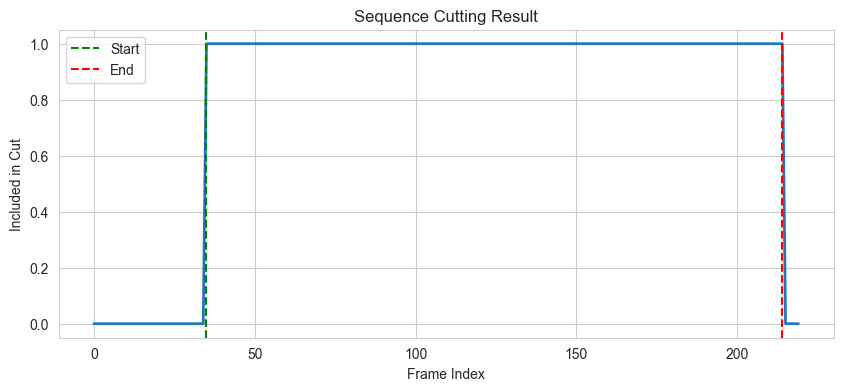

In [ ]:

import os
from joblib import load


file_path = "data/kinect_good/A90_kinect.csv" 

# Call the cutting function
cut_df, start_idx, end_idx = cut_sequence_with_distance_features(
    file_path,
    model_path="kinect_cutting_model_with_distances.keras",
    scaler_path="kinect_cutting_scaler_with_distances.pkl"
)

# Optionally save the cut sequence
output_path = os.path.join(os.path.dirname(file_path), f"cut_{os.path.basename(file_path)}")
cut_df.to_csv(output_path, index=False)
print(f"Cut sequence saved to: {output_path}")

# Visualize the cutting results
import matplotlib.pyplot as plt
import numpy as np

# Create a timeline visualization
plt.figure(figsize=(10, 4))
timeline = np.zeros(len(pd.read_csv(file_path)))
timeline[start_idx:end_idx+1] = 1

plt.plot(timeline, linewidth=2)
plt.axvline(x=start_idx, color='g', linestyle='--', label='Start')
plt.axvline(x=end_idx, color='r', linestyle='--', label='End')
plt.xlabel('Frame Index')
plt.ylabel('Included in Cut')
plt.title('Sequence Cutting Result')
plt.legend()
plt.grid(True)
plt.savefig(f'cut_visualization_{os.path.basename(file_path).replace(".csv", ".png")}')
plt.show()